In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os, glob
import re

/home/jaabir/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
K_depth = np.array([
      [475.62, 0, 311.125],
      [0, 475.62, 245.965],
      [0, 0, 1]
])

K_color = np.array([
    [617.173, 0, 315.453],
    [0, 617.173, 242.259],
    [0, 0, 1]
])

E_depth = np.eye(4)

E_color = np.array([
    [1, 0, 0, 24.7],
    [0, 1, 0, -0.0471401],
    [0, 0, 1, 3.72045],
    [0, 0, 0, 1]
])

In [3]:
def get_ipath(root):
    images = glob.glob(os.path.join(root, '*object', '*', '*', '*', '*on_depth.png'))
    return images

In [4]:
root = 'SynthHands_Release'
joints_pos = [
    'W', 
    'T0', 'T1', 'T2', 'T3', 
    'I0', 'I1', 'I2', 'I3', 
    'M0', 'M1', 'M2', 'M3', 
    'R0', 'R1', 'R2', 'R3', 
    'L0', 'L1', 'L2', 'L3'
]

In [5]:
images = get_ipath(root)
df = pd.DataFrame({
    'images' : images
}).sort_values(by = 'images').reset_index(drop = True)
pd.set_option('display.max_colwidth', None)
df['imageID'] = df.images.str.split('/').str[-1].str.split('_').str[0]
df['abs_path'] = df.images.apply(os.path.dirname)
df.head()

,images,imageID,abs_path
0,SynthHands_Release/female_noobject/seq01/cam01/01/00000000_color_on_depth.png,00000000,SynthHands_Release/female_noobject/seq01/cam01/01
1,SynthHands_Release/female_noobject/seq01/cam01/01/00000001_color_on_depth.png,00000001,SynthHands_Release/female_noobject/seq01/cam01/01
2,SynthHands_Release/female_noobject/seq01/cam01/01/00000002_color_on_depth.png,00000002,SynthHands_Release/female_noobject/seq01/cam01/01
3,SynthHands_Release/female_noobject/seq01/cam01/01/00000003_color_on_depth.png,00000003,SynthHands_Release/female_noobject/seq01/cam01/01
4,SynthHands_Release/female_noobject/seq01/cam01/01/00000004_color_on_depth.png,00000004,SynthHands_Release/female_noobject/seq01/cam01/01


In [54]:
img, id, apath = df.iloc[0]
fname = os.path.join(apath, f'{id}_joint_pos.txt')

In [30]:
with open(fname, 'r') as file:
    kpts = file.read()
kpts = re.split(r',|\n', kpts)[:-1]
kpts = np.array(list(map(float, kpts))).astype(np.float32).reshape(-1, 3)
ones = np.ones((kpts.shape[0], 1))
kpts = np.hstack((kpts, ones))

In [31]:
kpts.shape

(21, 4)

In [32]:
x_depth = np.dot(E_depth, kpts.T).T
x_color = np.dot(E_color, kpts.T).T

u_depth = (K_depth[0, 0] * x_depth[:, 0] / x_depth[:, 2]) + K_depth[0, 2]
v_depth = (K_depth[1, 1] * x_depth[:, 1] / x_depth[:, 2]) + K_depth[1, 2]
u_color = (K_color[0, 0] * x_color[:, 0] / x_color[:, 2]) + K_color[0, 2]
v_color = (K_color[1, 1] * x_color[:, 1] / x_color[:, 2]) + K_color[1, 2]
uv_depth = np.hstack((u_depth.reshape(-1, 1), v_depth.reshape(-1, 1))).astype(np.uint32)
uv_color = np.hstack((u_color.reshape(-1, 1), v_color.reshape(-1, 1))).astype(np.uint32)

In [33]:
uv_depth

array([[281, 343],
       [255, 293],
       [221, 263],
       [221, 229],
       [208, 194],
       [284, 239],
       [294, 198],
       [298, 169],
       [304, 141],
       [311, 245],
       [331, 203],
       [339, 172],
       [347, 145],
       [330, 252],
       [349, 207],
       [358, 178],
       [344, 171],
       [347, 263],
       [363, 234],
       [375, 211],
       [392, 188]], dtype=uint32)

In [34]:
uv_color 

array([[321, 367],
       [287, 302],
       [245, 264],
       [248, 220],
       [234, 176],
       [320, 233],
       [332, 180],
       [338, 143],
       [346, 108],
       [355, 242],
       [379, 187],
       [390, 147],
       [399, 112],
       [381, 249],
       [404, 192],
       [415, 155],
       [399, 145],
       [404, 264],
       [426, 227],
       [443, 198],
       [465, 168]], dtype=uint32)

In [42]:
import cv2 as cv
import matplotlib.colors as mcolors

def renderPose(img, uv, return_lbl = False):
    colors = ['black'] + ['blue'] * 4 + ['orange'] * 4 + ['lime'] * 4 + ['yellow'] * 4 +  ['cyan'] * 4
    joints_pos = [
    'W', 
    'T0', 'T1', 'T2', 'T3', 
    'I0', 'I1', 'I2', 'I3', 
    'M0', 'M1', 'M2', 'M3', 
    'R0', 'R1', 'R2', 'R3', 
    'L0', 'L1', 'L2', 'L3'
    ]
    
    if type(uv) == list:
        uv = np.array(uv)
    connections = [[0,1], [1,2], [2,3], [3,4], 
                   [0,5], [5,6], [6,7], [7,8], 
                   [0,9], [9,10],[10,11], [11,12],
                   [0,13],[13,14], [14,15], [15,16], 
                   [0,17],[17,18], [18,19], [19, 20],
                   [1,5], [5,9], [9,13], [13,17]
                  ]
    
    for c in connections:
        a,b = uv[c[0]].astype(int),uv[c[1]].astype(int)
        img = cv.line(img, a, b, (255,0,0), 1)
        
    for ind, point in enumerate(uv):
        
        color = colors[ind]
        rgb = tuple(map(lambda x : x * 255, mcolors.to_rgb(color)))
        img = cv.circle(img, point.astype(int), 1, rgb, 2)
        
    if return_lbl:
        return img, labels
        
    return img

def show_img_from_path(path, uv = None):
    img = plt.imread(path)
    show_img(img, uv)
    
def show_img(img, uv = None):
    plt.title(img.shape)
    plt.imshow(img if uv is None else renderPose(img, uv))
    plt.axis(False);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


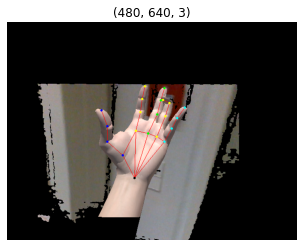

In [28]:
show_img_from_path(img, uv_depth)

In [52]:
import albumentations as A

def get_crop_uv(kpts, hw = (480, 640), thresh = 10):
    h,w = hw
    x1, x2 = np.min(kpts[:, 0]), np.max(kpts[:, 0])
    y1, y2 = np.min(kpts[:, 1]), np.max(kpts[:, 1])
    x1, x2 = max(0, x1 - thresh), min(x2 + thresh, w) 
    y1, y2 = max(0, y1 - thresh), min(y2 + thresh, h) 
    return x1,y1,x2,y2

def Transform(img, kpts, box):
    x1,y1,x2,y2 = box
    transform = A.Compose([
        A.Crop(x_min = x1, x_max = x2, y_min = y1, y_max = y2, always_apply= True, p=1),
        A.Resize(height = 224, width = 224, always_apply=True, p=1)
    ], keypoint_params = A.KeypointParams(format="xy", remove_invisible = False))
    transformed = transform(
          image=img,
          keypoints=kpts,
        )
    img  = transformed['image']
    kpts = transformed['keypoints']
    return img, kpts

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


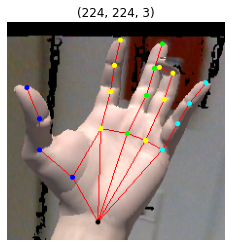

In [58]:
img, _,_ = df.iloc[0]
img, kpts = Transform(plt.imread(img).copy(), uv_depth, get_crop_uv(uv_depth, thresh = 20))
show_img(img, kpts)